##### This script will associate spoken phrases with their corresponding translation, using a convolutional neural network ("CNN")

This CNN will rely on all phrases from Female 1 that were spoken more than once, and have a recording using each of the two mics - head and array. The resulting data will have 4 or more records for each prompt. These records will be randomly assigned to train/test by prompt id using a 50/50 split. (e.g. for Female 1, the prompt "chair" was recorded twice in prompt id 46 and 73. In this case the head and array mic recording from prompt id 46 will be used for training, and then head and array mic recordings from prompt id 73 will be used for testing)

In the end, if the CNN can use the phrase spoken in one prompt to predict the same phrase spoken in another prompt, even though it has not used the other prompt to learn, then that should prove this approach works.

In [673]:
# ##### CNN Parameters #####

batch_size = 10
epochs = 100

image_height_width = 240  # Resize all images to square with this height and width
mean_norm_img = True  # Normalize frequency of all images
blurr_img = True      # Blurr all images with gaussian blur

# Do not use this with blurr_img
augment_images = False     # Apply random image augmentation on training batches

###########################

## (1) Load Packages and Functions

In [674]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import random

In [675]:
# ##### FUNCTIONS ##### #

def mean_norm(img):
    """
    A function that takes an image and deducts and divides by the column mean from each point of the array
    to normalize the frequency of each time frame.
    """
    img_mn = (img - (np.mean(img, axis=0) + 1e-8))  # / (np.mean(img, axis=0) + 1e-8)
    return img_mn

def augment_img(img, choose='random'):
    """
    A function that takes a 2D or 3D image and returns a randomly augmented version of the image,
    unless the augmentation type is specified on the call.
    """
    
    img_is_3d = False
    
    # Convert from 3D to 2D e.g. from (56, 56 , 1) to (56, 56)  * if the image came in as 3d
    if img.ndim == 3:
        img = np.squeeze(img)
        img_is_3d = True
    
    # Randomly choose augmentation method, unless specified
    if choose == 'random':
        options = ['AHE','CS','gamma','log','blurr_avg','blurr_gaus','blurr_median','None']
        choose = random.choice(options)
    
    # Adaptive Equalization
    if choose == 'AHE':
        img_new = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Contrast stretching
    if choose == 'CS':
        p2 = np.percentile(img, 2)
        p98 = np.percentile(img, 98)
        img_new = exposure.rescale_intensity(img, in_range=(p2, p98))
        
    # Gamma contrast adjustment
    if choose == 'gamma':
        img_new = exposure.adjust_gamma(img, 2)
    
    # Log contrast adjustment
    if choose == 'log':
        img_new = exposure.adjust_log(img, 1)
        
    # Image Blurring - Averaging  - Note: n X n window. Smaller images will be blurred more
    if choose == 'blurr_avg':
        img_new = cv2.blur(img,(3,3))
        
    # Image Blurring - Gaussian  - Note: n X n window. Smaller images will be blurred more
    if choose == 'blurr_gaus':
        img_new = cv2.GaussianBlur(img,(7,7),0)

    # Image Blurring - Median Filtering 
    if choose == 'blurr_median':
        img_new = cv2.medianBlur(img,5)
        
    # Do nothing
    if choose == 'None':
        img_new = img
    
    # Convert back to 3D * if the image came in as 3d
    if img_is_3d == True:
        img_new = np.reshape(img_new, (img_new.shape[0], img_new.shape[1], 1)) 
    
    return img_new

#########################

## (2) Load and Filter Data

In [676]:
# Load master index, and filter and assign to train and test using pandas

# Load prompt_id as text with leading zeros
df = pd.read_csv('../index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})
print('# rows in index file:', df.shape[0])

# (A) Remove instances where prompt is None OR prompts that begin with "[" or contain "jpg" OR where has_spect is No

df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.startswith('[')) | (df['has_spect']=='No')
df = df[df['remove']==False]
print('# rows with a prompt, and prompt does not contain [ or jpg:', df.shape[0])

# (B) Only keep instances where the recording was made on both the head and array mics

df_head = df[(df['mic']=='wav_headMic')]
df_array = df[(df['mic']=='wav_arrayMic')]

df_filter = pd.merge(df_head, df_array, on=['speaker','session','prompt_id'])
keep_id = df_filter['speaker'] + df_filter['session'] + df_filter['prompt_id']

df['keep_id'] = df['speaker'] + df['session'] + df['prompt_id']
df = df[df.keep_id.isin(keep_id)]
print('# rows with only prompts recorded on both mics:', df.shape[0]) 

# (C) Only keep instances where a prompt was recorded more than once

df_filter = df.groupby(['speaker','mic','prompt']).size().reset_index(name='counts')
df_filter = df_filter[df_filter['counts']>1]
keep_id = df_filter['speaker'] + df_filter['prompt']

df['keep_id'] = df['speaker'] + df['prompt']
df = df[df.keep_id.isin(keep_id)]
print('# rows with only prompts recorded more than once:', df.shape[0])

# rows in index file: 6179
# rows with a prompt, and prompt does not contain [ or jpg: 5656
# rows with only prompts recorded on both mics: 4942
# rows with only prompts recorded more than once: 1422


In [677]:
df = df.sort_values(by=['speaker','prompt','prompt_id','mic'])
df.head(10)

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,keep_id
163,F01,Session1,wav_arrayMic,0030,yes,165,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
29,F01,Session1,wav_headMic,0030,yes,151,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
164,F01,Session1,wav_arrayMic,0031,yes,155,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
30,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
148,F01,Session1,wav_arrayMic,0015,yes,57,513,air,False,F01air
14,F01,Session1,wav_headMic,0015,yes,67,513,air,False,F01air
212,F01,Session1,wav_arrayMic,0079,yes,61,513,air,False,F01air
78,F01,Session1,wav_headMic,0079,yes,39,513,air,False,F01air
162,F01,Session1,wav_arrayMic,0029,yes,57,513,beat,False,F01beat
28,F01,Session1,wav_headMic,0029,yes,50,513,beat,False,F01beat


## (3) Assign Data to Test and Train Sets

In [678]:
# Using the head Mic data, Sort the df by speaker, prompt, and prompt id
# Alternate assigning each row to train and test
# Then use that to join the assignment to the main dataframe, in order to tag the array Mic data with train/test

df_filter = df[df['mic']=='wav_headMic'].sort_values(by=['speaker','prompt','prompt_id'])

df_filter['train'] = 0
train = 1
for index, row in df_filter.iterrows():
    df_filter.at[index,'train'] = train
    train *= -1

df_filter = df_filter[['speaker','session','prompt_id','train']]

df = pd.merge(df, df_filter, on=['speaker','session','prompt_id'])

In [679]:
# *** FOR NOW ONLY USE FEMALE 1 *** We can alter this later
df = df[df['speaker']=='F01']

# Add numerical prompt codes once final data set is compiled
df.prompt = pd.Categorical(df.prompt)
df['prompt_code'] = df.prompt.cat.codes

df.head(80)

num_classes = df['prompt_code'].max() + 1
print('Number of rows for Female 1:', df.shape[0])
print('Number of unique prompts for Female 1: ', num_classes)
df.head(80)

Number of rows for Female 1: 78
Number of unique prompts for Female 1:  18


,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,keep_id,train,prompt_code
0,F01,Session1,wav_arrayMic,0030,yes,165,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,1,0
1,F01,Session1,wav_headMic,0030,yes,151,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,1,0
2,F01,Session1,wav_arrayMic,0031,yes,155,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,-1,0
3,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,-1,0
4,F01,Session1,wav_arrayMic,0015,yes,57,513,air,False,F01air,1,1
5,F01,Session1,wav_headMic,0015,yes,67,513,air,False,F01air,1,1
6,F01,Session1,wav_arrayMic,0079,yes,61,513,air,False,F01air,-1,1
7,F01,Session1,wav_headMic,0079,yes,39,513,air,False,F01air,-1,1
8,F01,Session1,wav_arrayMic,0029,yes,57,513,beat,False,F01beat,1,2
9,F01,Session1,wav_headMic,0029,yes,50,513,beat,False,F01beat,1,2


## (4) Resize All Images

I initially tried padding the spectrogram images so that they were all squares and the same size...

- I believe the CNN requires these images to be the same size. They are currently all the same height (frequency axis), but are not the same width (time axis). Therefore, we can pad the end of each image so that all of the images are also the same width using the max width of all the images. The CNN I set up requires the images to be squares, and dimensions should be an even number since they may be divided by two one or twice during the CNN. I set up the padding to pad the bottom of the y axis (frequency) with a replication of what is above it, that way the information is still useful for prediction, rather than just padding it with gray like the x axis (time) axis.

However, I realized that this resulted in images that were too large, so I added the ability to resize/shrink the images...

- This approach works better. I think we can ignore padding for now, and just resize the original images.

[Tutorial for Padding with OpenCV](https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html)

In [680]:
# Get all predictor variables (padded images) and outcome variable (prompt), and train/test assignment
# Resize images

images_orig = []
images = []
prompts = []
train = []

maxwidth = image_height_width

for index, row in df.iterrows(): 
    img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'.png'])
    
    # Original image
    img = cv2.imread(img_loc, 0)
    images_orig.append(img) 
    
    # Resize image
    img = cv2.resize(img, (maxwidth, maxwidth))
    images.append(img)   
    
    prompts.append(row['prompt_code'])
    train.append(row['train'])
    
for i in images[0:2]:
    print('Shape:', i.shape)

Shape: (240, 240)
Shape: (240, 240)


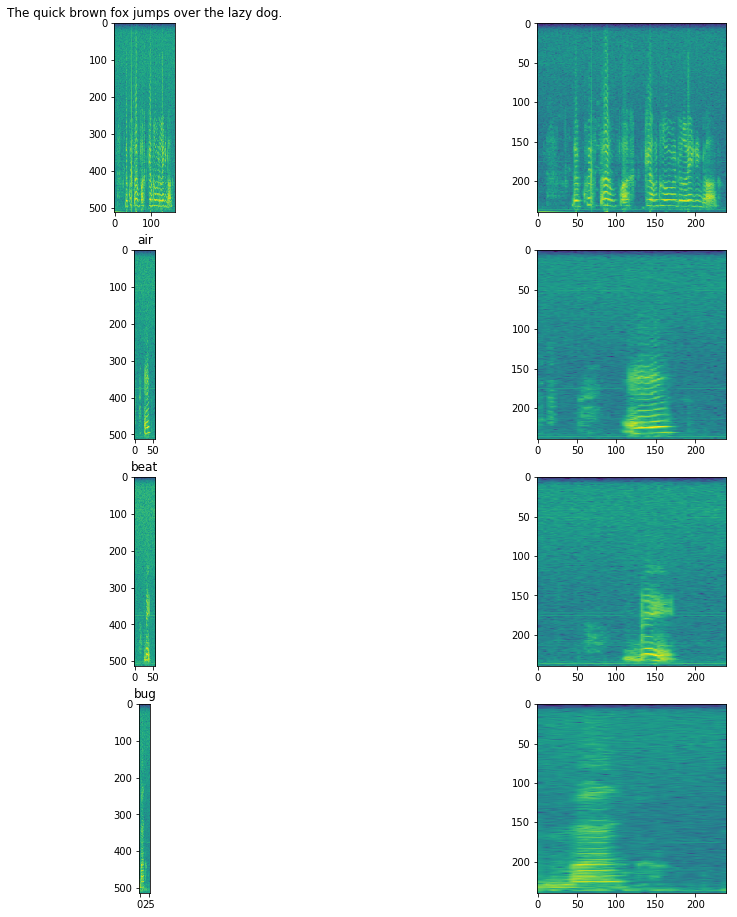

In [681]:
# View examples before and after re-size

cat = dict( enumerate(df['prompt'].cat.categories))  # Dictionary to look up prompt text from prompt code
num_examples = 4

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(num_examples,2,2*i + 1),plt.imshow(images_orig[i*4]),plt.title(cat.get(prompts[i*4]))
    plt.subplot(num_examples,2,2*i + 2),plt.imshow(images[i*4])

## Explore Images and Augmentation

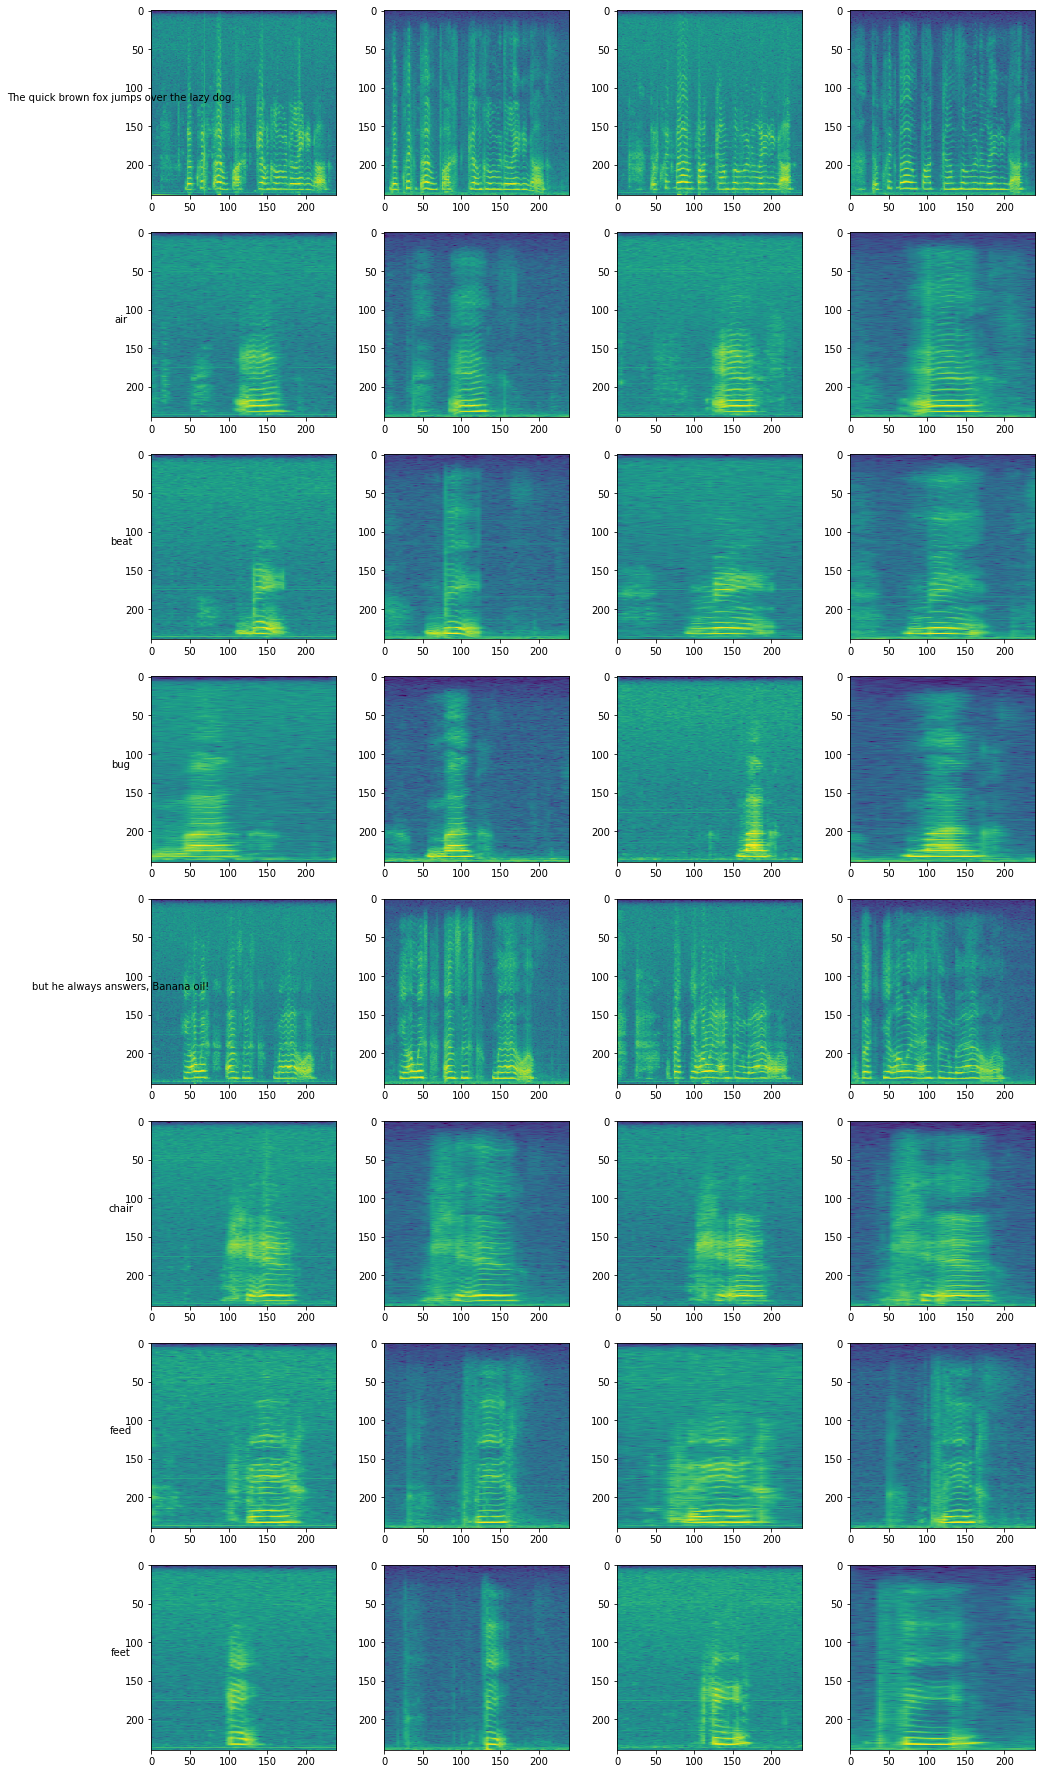

In [682]:
# Show matrix of spectrograms for a sample of prompts, in order to visualize similarities and differences
# These have NO augmentation, except for being resized

fig = plt.figure(figsize=(16, 32))
cnt = 1

# Get first n examples of prompts
num_examples = 8
for p in range(num_examples):
    # Get images for given prompt
    p_image = [images[i] for i,x in enumerate(prompts) if x==p]
    
    for i in range(4):
        plt.subplot(num_examples,4,cnt),plt.imshow(p_image[i])
        if i==0: plt.ylabel(cat.get(p),rotation=0)
        cnt += 1


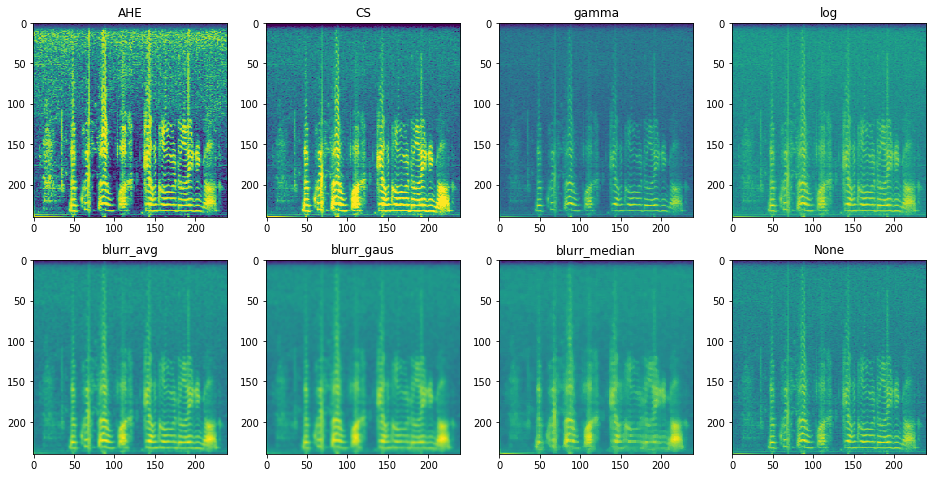

In [683]:
# ##### View examples of each image augmentation type in our function ##### #

aug_type = ['AHE','CS','gamma','log','blurr_avg','blurr_gaus','blurr_median','None']
    
fig = plt.figure(figsize=(16, 8))

for i, aug in enumerate(aug_type):
    img_new = augment_img(images[0], aug)
    imgplot_new = plt.subplot(2,4,i+1),plt.imshow(np.squeeze(img_new)),plt.title(aug)
    

(<matplotlib.axes._subplots.AxesSubplot at 0x29416bc4f28>,
 Text(0.5,1,'After MN & Blur'))

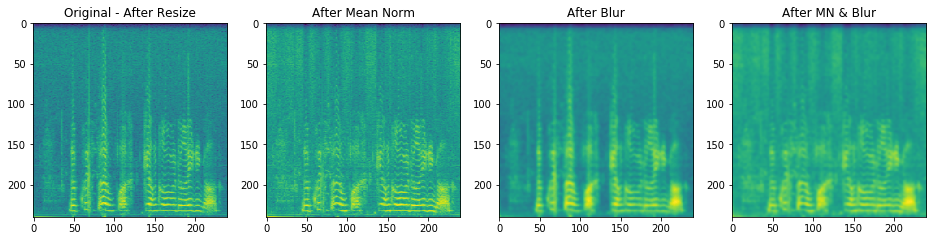

In [684]:
# View examples of mean normalization with gaussian blur

fig = plt.figure(figsize=(16, 16))

plt.subplot(1,4,1), plt.imshow(images[0]),plt.title('Original - After Resize')
plt.subplot(1,4,2), plt.imshow(mean_norm(images[0])),plt.title('After Mean Norm')
plt.subplot(1,4,3), plt.imshow(augment_img(images[0],'blurr_gaus')),plt.title('After Blur')
plt.subplot(1,4,4), plt.imshow(augment_img(mean_norm(images[0]),'blurr_gaus')),plt.title('After MN & Blur')

#print('Before mean norm:', images[0])
#print('After mean norm:', mean_norm(images[0]))

## (5) Set up and run CNN

Simple model is based on [this](https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/)

VGG model is based on [this](https://blogs.technet.microsoft.com/machinelearning/2018/01/30/hearing-ai-getting-started-with-deep-learning-for-audio-on-azure/)

In [685]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential

from keras.layers import Activation
from keras.layers import Convolution2D, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adamax
from keras.regularizers import l2
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

In [686]:
# ############## IMAGE AUGMENTATION ############### #

if mean_norm_img == True:
    images_new = []
    for i in images:
        images_new.append(mean_norm(i))
    images = images_new

if blurr_img == True:
    images_new = []
    for i in images:
        images_new.append(augment_img(i,'blurr_gaus'))
    images = images_new

if augment_images:
    # This also shifts the images horizontal or vertial by +/- x %
    datagen = ImageDataGenerator(width_shift_range=0.05, height_shift_range=0.05, preprocessing_function=augment_img)
else:
    datagen = ImageDataGenerator()

#####################################################

In [687]:
# Split data into training and testing
x_train_pre = np.array([images[i] for i,x in enumerate(train) if x==1])
y_train_pre = np.array([prompts[i] for i,x in enumerate(train) if x==1])
x_test_pre = np.array([images[i] for i,x in enumerate(train) if x==-1])
y_test_pre = np.array([prompts[i] for i,x in enumerate(train) if x==-1])

x_train = x_train_pre
y_train = y_train_pre
x_test = x_test_pre
y_test = y_test_pre

print('Number of training records:', len(y_train))
print('Number of test records:', len(y_test))

Number of training records: 40
Number of test records: 38


In [688]:
# input image dimensions
img_x, img_y = maxwidth, maxwidth

In [689]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because it is in greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

In [690]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (40, 240, 240, 1)
40 train samples
38 test samples


In [691]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [692]:
# "Simple" Network (This is not the VGG network)

model = Sequential()

# Convolution 1st layer
model.add(Conv2D(64, kernel_size=(6, 6), strides=(4, 4),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape,
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution 2nd layer
model.add(Conv2D(32, (4, 4), activation='relu', padding = 'same',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution 3rd layer
model.add(Conv2D(16, (2, 2), activation='relu', padding = 'same',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# # Fully connected layer 2
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization()) 

# Fully connected layer 3
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [693]:
# # VGG based network

# model = Sequential()

# # section 1

# model.add(Convolution2D(filters=32, kernel_size=5,
#                         strides=2,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal",
#                         input_shape=input_shape))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=32, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.3))

# # section 2    
# model.add(Convolution2D(filters=64, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=64, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# # section 3
# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# # section 4
# model.add(Convolution2D(filters=512, kernel_size=3,
#                         strides=1,
#                         padding="valid",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Convolution2D(filters=512, kernel_size=1,
#                         strides=1,
#                         padding="valid",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# # section 5
# model.add(Convolution2D(filters=num_classes, kernel_size=1,
#                         strides=1,
#                         padding="valid",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(GlobalAveragePooling2D())

# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adamax(0.01))

In [694]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [695]:
history = AccuracyHistory()

In [696]:
datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=x_train.shape[0] // batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4/4 [==============================] - 12s 3s/step - loss: 4.3117 - acc: 0.0250 - val_loss: 7.3905 - val_acc: 0.1579
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 2.7677 - acc: 0.3750 - val_loss: 6.0467 - val_acc: 0.1579
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 2.2019 - acc: 0.6750 - val_loss: 3.7083 - val_acc: 0.1579
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 1.7263 - acc: 0.8000 - val_loss: 4.1454 - val_acc: 0.1053
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 1.4797 - acc: 0.8000 - val_loss: 5.3081 - val_acc: 0.1579
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 1.2511 - acc: 0.9500 - val_loss: 10.6973 - val_acc: 0.0263
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 1.1751 - acc: 0.9750 - val_loss: 11.8523 - val_acc: 0.0263
Epoch 8/100
4/4 [==============================] - 5s 1s/step - loss: 1.2530 - acc: 0.9750 - val_loss

4/4 [==============================] - 5s 1s/step - loss: 0.4686 - acc: 1.0000 - val_loss: 2.6416 - val_acc: 0.3421
Epoch 65/100
4/4 [==============================] - 5s 1s/step - loss: 0.4614 - acc: 1.0000 - val_loss: 2.6299 - val_acc: 0.3421
Epoch 66/100
4/4 [==============================] - 5s 1s/step - loss: 0.4540 - acc: 1.0000 - val_loss: 2.6159 - val_acc: 0.3421
Epoch 67/100
4/4 [==============================] - 4s 1s/step - loss: 0.4568 - acc: 1.0000 - val_loss: 2.6111 - val_acc: 0.3421
Epoch 68/100
4/4 [==============================] - 4s 1s/step - loss: 0.4589 - acc: 1.0000 - val_loss: 2.6215 - val_acc: 0.3421
Epoch 69/100
4/4 [==============================] - 4s 1s/step - loss: 0.4471 - acc: 1.0000 - val_loss: 2.6262 - val_acc: 0.3421
Epoch 70/100
4/4 [==============================] - 5s 1s/step - loss: 0.4544 - acc: 1.0000 - val_loss: 2.6230 - val_acc: 0.3158
Epoch 71/100
4/4 [==============================] - 5s 1s/step - loss: 0.4401 - acc: 1.0000 - val_loss: 2.6117

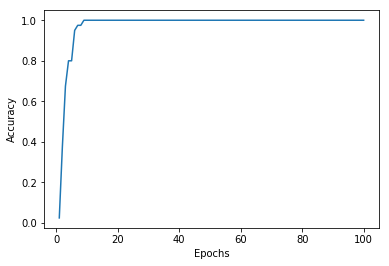

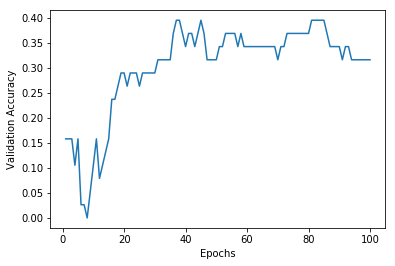

In [699]:
plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(1, epochs + 1), history.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

##### Notes on results:

##### simple network + width = 112

1) using both mean-norm and blurr hit a peak of 39% accuracy
- increasing width to 150 also hit 39% and had more epochs hit 39%
- increasing width to 200 hits 39% after more epochs
- (width 200) 5x5 blurr window instead of 3x3 gets to 42% accuracy  ***** BEST *****
- (width 200) 7x7 blurr window instead of 3x3 gets to 36% accuracy
- (width 250) 7x7 blurr window gets to 39% accuracy
- (width 150) using VGG network trains slower and hits 23% (more bumpy and falls quicker at end also)

2) using only random augment on training data hit 18%

3) using only mean-norm 31%

4) using only blurr hit 23%

5) running as is with no image edits (except resize) hit 28%


##### Ideas to improve

- [Use Keras to augment spectrograms, rather than the audio files](https://keras.io/preprocessing/image/)
    - [An example](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085)
- [Use rubberband for audio file augmentation to build more training data](https://www.skcript.com/svr/building-audio-classifier-nueral-network/)
    - [Other non-rubberband augmentation code](https://github.com/drscotthawley/audio-classifier-keras-cnn/blob/master/augment_data.py)
- Try other hyper-parameters? (Dropout, learning rate, etc. Adding batch normalization seemed to help a little)
- Re-size spectrogram by creating a smaller freq axis, and randomly adding and removing time slices [Example code](https://github.com/dawidkopczyk/speech_recognition/blob/master/dataset.py)
- Use a different CNN structure, or use a recurrent CNN on the original images without shrinking?
    - [This example](https://blogs.technet.microsoft.com/machinelearning/2018/01/30/hearing-ai-getting-started-with-deep-learning-for-audio-on-azure/) relies on a structure that has been known to perform well, and uses windowing and mel-spectrogram?
- Rather than using deep learning, use feature engineerings and autmated machine learning: Scale-invariant Feature Transform (SIFT) features + TPOT

In [698]:
# View actual vs predicted phrases

# model.predict(x_test)  # view prediction probabilities
predictions = model.predict_classes(x_test, verbose=1)
cat = dict( enumerate(df['prompt'].cat.categories) )
print(cat)

for i, val in enumerate(y_test_pre):
    print('Actual:', cat.get(val))
    print('Predicted:', cat.get(predictions[i]))
    print('----------------------------------------')

    
#Here is code for plotting 9 images in a 3x3 matrix. Can leverage this to print examples
# images = range(0,9)
# for i in images:
#     plt.subplot(330 + 1 + i)
#     plt.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

38/38 [==============================] - 3s 70ms/step
{0: 'The quick brown fox jumps over the lazy dog.', 1: 'air', 2: 'beat', 3: 'bug', 4: 'but he always answers, Banana oil!', 5: 'chair', 6: 'feed', 7: 'feet', 8: 'knew', 9: 'meat', 10: 'rave', 11: 'read [as in I can read]', 12: 'sip', 13: 'storm', 14: 'swarm', 15: 'the', 16: 'warm', 17: 'yet he still thinks as swiftly as ever.'}
Actual: The quick brown fox jumps over the lazy dog.
Predicted: yet he still thinks as swiftly as ever.
----------------------------------------
Actual: The quick brown fox jumps over the lazy dog.
Predicted: yet he still thinks as swiftly as ever.
----------------------------------------
Actual: air
Predicted: beat
----------------------------------------
Actual: air
Predicted: beat
----------------------------------------
Actual: beat
Predicted: beat
----------------------------------------
Actual: beat
Predicted: beat
----------------------------------------
Actual: bug
Predicted: but he always answers, Ba